In [1]:
from data import preparation
import data.hierarchy as hie
from sklearn.model_selection import train_test_split

In [2]:
data_name = "wipo_d"

In [3]:
with open('data/%s/hierarchy.txt' % data_name, 'w') as f1:
    with open('data/%s/%s.ht' % (data_name,data_name)) as f:
        for l in f:
            split = l.strip().split(':')
            p = split[0]
            c = split[1].split(',')
            for cc in c:
                f1.write('%s %s\n'% (p,cc))

In [4]:
hierarchy, parent_of, all_name, name_to_index, level = hie.reindex_hierarchy(
                '%s/hierarchy.txt' % data_name)
hie.save_hierarchy("%s/hierarchy.pickle" % data_name, hierarchy,
                   parent_of, all_name, name_to_index, level)

In [5]:
for mode in ['train', 'test']:
    for i in range(1,6):
        datas, labels = preparation.import_data('%s/folds/%s_fold%d.dat.%s' % (data_name, data_name, i, mode))
        new_labels = preparation.map_index_of_label('%s/hierarchy.pickle' % data_name, labels)
        if mode == 'train':
            train_data, validate_data, train_target, validate_target = train_test_split(
                datas, new_labels, test_size=0.1, random_state=12345)
            preparation.save_data_in_pickle('%s/fold/data_%d.pickle.%s' % (data_name, i, mode), train_data, train_target)
            preparation.save_data_in_pickle('%s/fold/data_%d.pickle.%s' % (data_name, i, "validate"), validate_data, validate_target)
        else:
            preparation.save_data_in_pickle('%s/fold/data_%d.pickle.%s' % (data_name, i, mode), datas, new_labels)

# Real Flow 

In [6]:
from data import Dataset
from embedding import Doc2Vec
from assemble_classifier import AssembleNoLabel, AssemblePredicted,AssemblePredictedHidden
import shutil
import os

%load_ext autoreload
%autoreload 2

In [7]:
fold = 3

In [8]:
dataset_train = Dataset(data_name, fold, "train")

In [9]:
doc2vec = Doc2Vec(dataset_train.number_of_classes(), size=100, epoch=100)

Doc2Vec by Gensim


In [10]:
f1_array = []
same = []
diff = []
avg_diff = []
top_k = []

In [11]:
%%time
for i in range(5):
    dataset_train = Dataset(data_name, fold, "train")
    dataset_validate = Dataset(data_name, fold, "validate")
    dataset_test = Dataset(data_name, fold, "test")
    s, d, a, t = doc2vec.fit(dataset_train.datas, dataset_train.labels, dataset_validate.datas, dataset_validate.labels, early_stopping=False, second_run=i!=0)
    same.append(s)
    diff.append(d)
    avg_diff.append(a)
    top_k.append(t)
    # doc2vec.load_model("best_now/doc2vec.model")

    dataset_train.change_to_Doc2Vec(doc2vec)
    dataset_validate.change_to_Doc2Vec(doc2vec)
    dataset_test.change_to_Doc2Vec(doc2vec)
    
    if os.path.isdir('data/%s/output' % data_name):
        shutil.rmtree('data/%s/output' % data_name)

#     model = AssemblePredicted(data_name, dataset_train, dataset_validate, dataset_test, iteration=20000, batch_size=20000, hidden_size=[300,1500,2000,2500], target_hidden_size=[60,100,120], use_dropout=True, start_level=0)
    # model = AssembleNoLabel(data_name, dataset_train, dataset_validate, dataset_test, iteration=2000, batch_size=100, hidden_size=[300,1500,1500,1500], use_dropout=False, start_level=0, end_level=100)

    model = AssemblePredictedHidden(data_name, dataset_train, dataset_validate, dataset_test, iteration=20000, batch_size=2000, hidden_size=[300,1500,2000,2500], use_dropout=True, start_level=0, end_level=100)
    model.train()
    model.tuning_threshold()

    f1_macro, f1_micro, f1_each = model.evaluate("train", correction=True)
    print("F1 macro: %.4f F1 micro: %.4f" % (f1_macro, f1_micro))
    for level, (macro, micro) in enumerate(f1_each):
        print("Level: %d F1 macro: %.4f F1 micro: %.4f" % (level, macro, micro))

    f1_macro, f1_micro, f1_each = model.evaluate("validate", correction=True)
    print("F1 macro: %.4f F1 micro: %.4f" % (f1_macro, f1_micro))
    for level, (macro, micro) in enumerate(f1_each):
        print("Level: %d F1 macro: %.4f F1 micro: %.4f" % (level, macro, micro))

    f1_macro, f1_micro, f1_each = model.evaluate("test", correction=True)
    f1_array.append(f1_macro)
    print("F1 macro: %.4f F1 micro: %.4f" % (f1_macro, f1_micro))
    for level, (macro, micro) in enumerate(f1_each):
        print("Level: %d F1 macro: %.4f F1 micro: %.4f" % (level, macro, micro))

Epoch: 2 Similar: 60.69
Epoch: 4 Similar: 17.19
Epoch: 6 Similar: 10.93
Epoch: 8 Similar: 9.27
Epoch: 10 Similar: 7.93
Epoch: 12 Similar: 5.62
Epoch: 14 Similar: 3.38
Epoch: 16 Similar: 3.48
Epoch: 18 Similar: 4.06
Epoch: 20 Similar: 4.61
Epoch: 22 Similar: 5.30
Epoch: 24 Similar: 6.96
Epoch: 26 Similar: 7.86
Epoch: 28 Similar: 9.34
Epoch: 30 Similar: 10.54
Epoch: 32 Similar: 12.02
Epoch: 34 Similar: 12.85
Epoch: 36 Similar: 13.93
Epoch: 38 Similar: 14.43
Epoch: 40 Similar: 14.82
Epoch: 42 Similar: 15.46
Epoch: 44 Similar: 16.08
Epoch: 46 Similar: 16.46
Epoch: 48 Similar: 16.52
Epoch: 50 Similar: 16.35
Epoch: 52 Similar: 16.48
Epoch: 54 Similar: 17.45
Epoch: 56 Similar: 16.57
Epoch: 58 Similar: 17.01
Epoch: 60 Similar: 16.86
Epoch: 62 Similar: 17.13
Epoch: 64 Similar: 16.77
Epoch: 66 Similar: 16.67
Epoch: 68 Similar: 16.90
Epoch: 70 Similar: 16.53
Epoch: 72 Similar: 16.51
Epoch: 74 Similar: 16.55
Epoch: 76 Similar: 16.41
Epoch: 78 Similar: 15.80
Epoch: 80 Similar: 15.84
Epoch: 82 Simil

Level: 2.000 Epoch: 1998/20000 Batch: 1/1 Loss: 0.717 Training F1 macro: 0.961 Validate F1 macro: 0.354
Level: 2.000 Epoch: 2629/20000 Batch: 1/1 Loss: 0.565 Stopping F1 macro: 0.974 Validate F1 macro: 0.390

Level: 3.000 Epoch: 666/20000 Batch: 1/1 Loss: 2.455  Training F1 macro: 0.224 Validate F1 macro: 0.024
Level: 3.000 Epoch: 1332/20000 Batch: 1/1 Loss: 1.169 Training F1 macro: 0.793 Validate F1 macro: 0.042
Level: 3.000 Epoch: 1998/20000 Batch: 1/1 Loss: 0.654 Training F1 macro: 0.891 Validate F1 macro: 0.051
Level: 3.000 Epoch: 2664/20000 Batch: 1/1 Loss: 0.404 Training F1 macro: 0.916 Validate F1 macro: 0.065
Level: 3.000 Epoch: 3330/20000 Batch: 1/1 Loss: 0.287 Training F1 macro: 0.921 Validate F1 macro: 0.059
Level: 3.000 Epoch: 3403/20000 Batch: 1/1 Loss: 0.293 Stopping F1 macro: 0.921 Validate F1 macro: 0.068

Level: 4.000 Epoch: 666/20000 Batch: 1/1 Loss: 3.649  Training F1 macro: 0.011 Validate F1 macro: 0.001
Level: 4.000 Epoch: 1332/20000 Batch: 1/1 Loss: 1.510 Training

Level: 4.000 Epoch: 1332/20000 Batch: 1/1 Loss: 1.191 Training F1 macro: 0.637 Validate F1 macro: 0.005
Level: 4.000 Epoch: 1998/20000 Batch: 1/1 Loss: 0.596 Training F1 macro: 0.828 Validate F1 macro: 0.008
Level: 4.000 Epoch: 2186/20000 Batch: 1/1 Loss: 0.480 Stopping F1 macro: 0.842 Validate F1 macro: 0.009

F1 macro: 0.8281 F1 micro: 0.8609
Level: 0 F1 macro: 0.8525 F1 micro: 0.7906
Level: 1 F1 macro: 0.9532 F1 micro: 0.9235
Level: 2 F1 macro: 0.8915 F1 micro: 0.8888
Level: 3 F1 macro: 0.8083 F1 micro: 0.8522
F1 macro: 0.0593 F1 micro: 0.4356
Level: 0 F1 macro: 0.5076 F1 micro: 0.6087
Level: 1 F1 macro: 0.5081 F1 micro: 0.5212
Level: 2 F1 macro: 0.1239 F1 micro: 0.3253
Level: 3 F1 macro: 0.0245 F1 micro: 0.1912
F1 macro: 0.0801 F1 micro: 0.4571
Level: 0 F1 macro: 0.5077 F1 micro: 0.6471
Level: 1 F1 macro: 0.4818 F1 micro: 0.5624
Level: 2 F1 macro: 0.1596 F1 micro: 0.3363
Level: 3 F1 macro: 0.0433 F1 micro: 0.1772
CPU times: user 11min 34s, sys: 2min 11s, total: 13min 45s
Wall time:

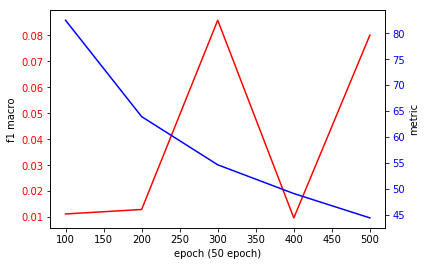

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def two_scales(ax1, time, data1, data2, c1, c2):
    ax2 = ax1.twinx()

    ax1.plot(time, data1, color=c1)
    ax1.set_xlabel('epoch (50 epoch)')
    ax1.set_ylabel('f1 macro')

    ax2.plot(time, data2, color=c2)
    ax2.set_ylabel('metric')
    return ax1, ax2

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

# Create some mock data
t = np.arange(100, 600, 100)
s1 = np.array(f1_array)
s2 = np.array(same)

# Create axes
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax, t, s1, s2, 'r', 'b')

color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')
plt.show()

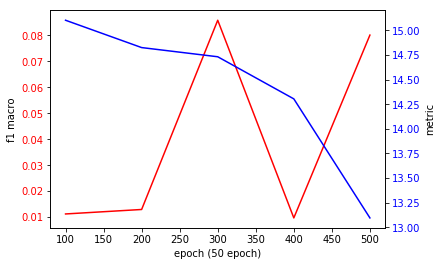

In [13]:

# Create some mock data
s1 = np.array(f1_array)
s2 = np.array(diff)

# Create axes
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax, t, s1, s2, 'r', 'b')

color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')
plt.show()

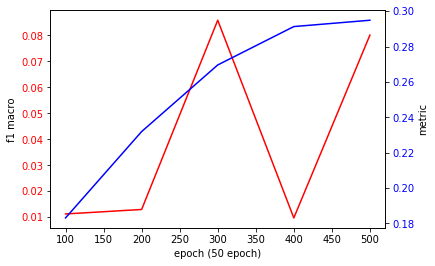

In [14]:

# Create some mock data
s1 = np.array(f1_array)
s2 = np.array(avg_diff)

# Create axes
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax, t, s1, s2, 'r', 'b')

color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')
plt.show()

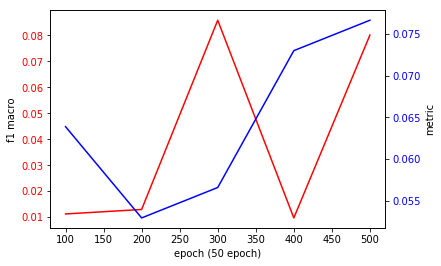

In [15]:

# Create some mock data
s1 = np.array(f1_array)
s2 = np.array(top_k)

# Create axes
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax, t, s1, s2, 'r', 'b')

color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')
plt.show()